# Simulation code

Try the below situations. Both of them are observable heterogeneity. And not high dimensional case.

1. $y_i = x_i^{'} \beta + \gamma d_i + \epsilon_i$
3. $y_i = x_i^{'} \beta + d_i x_i^{'} \gamma + \epsilon_i$

$x_i = (1,\ z_i)^{'}$ where $z_i \sim N(0,1)$.

In [2]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

## specification 1
$\beta = (1,-1)^{'}, \gamma = 1$

In [72]:
# data generation
np.random.seed(0)
sample_size = 100000
half_size = int(sample_size/2)
z = np.random.normal(size = (sample_size,1))
d1 = np.ones((half_size,1))
d0 = np.zeros((half_size,1))
d = np.vstack((d0,d1))
const = np.ones((sample_size,1))
x = np.hstack((np.hstack((const, z)), d))
y = 1 + -z + d + np.random.normal(scale = 0.5, size = (sample_size,1))

# make counter X
d1_counter = np.zeros((half_size,1))
d0_counter = np.ones((half_size,1))
d_counter = np.vstack((d0_counter, d1_counter))
x_counter = np.hstack((np.hstack((const, z)), d_counter))

### regression

In [5]:
# regression
regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(x, y)

# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[ 0.99711691 -0.99813625  1.00582469]]


### neural nets

In [6]:
# neural nets
nn = MLPRegressor(hidden_layer_sizes=(10, ))
nn.fit(x, y)

/Users/keiikegami/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [19]:
# effect prediction on training sample
effec_on_nontreat = nn.predict(x_counter)[0:half_size] - nn.predict(x)[0:half_size]
effec_on_treat = nn.predict(x)[half_size:] - nn.predict(x_counter)[half_size:]

In [22]:
np.mean(effec_on_nontreat)

1.0076118531667566

In [23]:
np.mean(effec_on_treat)

1.0076121247729286

In [29]:
np.var(effec_on_nontreat)

0.0003308498320210379

In [30]:
np.var(effec_on_treat)

0.00032470210288134484

In [27]:
# effect on new samples
z_new = np.random.normal(size = (sample_size,1))

x_new1 = np.hstack((np.hstack((const, z_new)), np.ones((sample_size,1))))
x_new0 = np.hstack((np.hstack((const, z_new)), np.zeros((sample_size,1))))

effect_on_newsample = nn.predict(x_new1) - nn.predict(x_new0)

In [28]:
np.mean(effect_on_newsample)

1.0075487018840896

In [31]:
np.var(effect_on_newsample)

0.00033511288999682454

### specification 2

This specification include the cross terms in the true model. 

$y_i = 1 - z_i + d_i + \frac{1}{2}z_i d_i + \epsilon_i$

So the treatment effect on the person whose $Z = z_i$ is $1+\frac{1}{2}z_i$.

In [85]:
# data generation
np.random.seed(0)
sample_size = 100000
half_size = int(sample_size/2)
z = np.random.normal(size = (sample_size,1))
d1 = np.ones((half_size,1))
d0 = np.zeros((half_size,1))
d = np.vstack((d0,d1))
cross = np.multiply(z, d)
const = np.ones((sample_size,1))
x = np.hstack((np.hstack((np.hstack((const, z)), d)), cross))
y = 1 + -z + d + 1/2*cross + np.random.normal(scale = 0.5, size = (sample_size,1))

# make counter X
d1_counter = np.zeros((half_size,1))
d0_counter = np.ones((half_size,1))
d_counter = np.vstack((d0_counter, d1_counter))
cross_counter = np.multiply(z, d_counter)
x_counter = np.hstack((np.hstack((np.hstack((const, z)), d_counter)), cross_counter))

### regression

In [86]:
# regression
regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(x, y)

# The coefficients
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[ 1.00535582 -1.00286055  0.99434548  0.50649793]]


In [87]:
# the estimated individual treatment effects
estimated_ITE = [regr.coef_[0][2] + regr.coef_[0][3]*i[0] for i in z]
true_ITE = [1 + 1/2*i[0] for i in z]

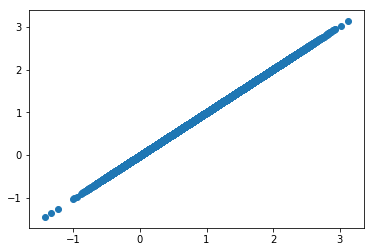

In [88]:
plt.scatter(true_ITE, estimated_ITE)

In [89]:
# distance
diff = np.subtract(true_ITE, estimated_ITE)
dist_reg = np.sqrt(np.sum([i**2 for i in diff]))
dist_reg

2.7176581774539823

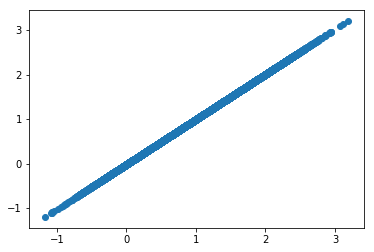

In [91]:
# effect on new sample
z_new = np.random.normal(size = (sample_size,1))
true_ITE_newsample = [1 + 1/2 * i[0] for i in z_new]
estimated_ITE_newsamplereg = [regr.coef_[0][2] + regr.coef_[0][3]*i[0] for i in z_new]
plt.scatter(true_ITE_newsample, estimated_ITE_newsamplereg)

In [93]:
diff = np.subtract(true_ITE_newsample, estimated_ITE_newsamplereg)
dist_reg2 = np.sqrt(np.sum([i**2 for i in diff]))
dist_reg2

2.714807658272234

### neural nets

In [78]:
# neural nets
# layerは2みたいに少なすぎるとダメ
# 10がちょうどいい
# 100とかデカ過ぎてもダメ
# activationでも結構変わる。identity、reluは良い。logistic, tanhはダメ
nn = MLPRegressor(hidden_layer_sizes=(10, ), activation='identity')
nn.fit(x, y)

/Users/keiikegami/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='identity', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [79]:
# effect prediction on training sample 1
effec_on_nontreat = nn.predict(x_counter)[0:half_size] - nn.predict(x)[0:half_size]
effec_on_treat = nn.predict(x)[half_size:] - nn.predict(x_counter)[half_size:]

In [80]:
ITE_on_sample = np.hstack((effec_on_nontreat, effec_on_treat))

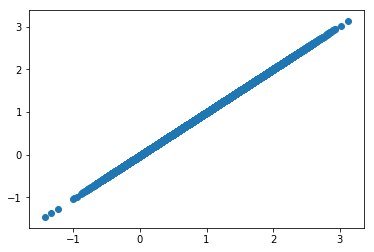

In [81]:
plt.scatter(true_ITE, ITE_on_sample)

In [82]:
diff_nn = np.subtract(ITE_on_sample, true_ITE)
dist_nn = np.sqrt(np.sum([i**2 for i in diff_nn]))
dist_nn

3.4063029015261717

In [83]:
# effect prediction on training sample 2
# こっちの方が悪くなるの意外?
effec_on_nontreat2 = nn.predict(x_counter)[0:half_size] - y[0:half_size].T
effec_on_treat2 = y[half_size:].T - nn.predict(x_counter)[half_size:]
ITE_on_sample2 = np.hstack((effec_on_nontreat2, effec_on_treat2))
diff_nn2 = np.subtract(ITE_on_sample2, true_ITE)
dist_nn2 = np.sqrt(np.sum([i**2 for i in diff_nn2]))
dist_nn2

157.9386392854199

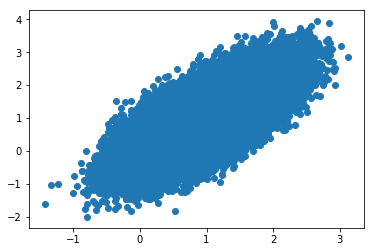

In [84]:
plt.scatter(true_ITE, ITE_on_sample2)

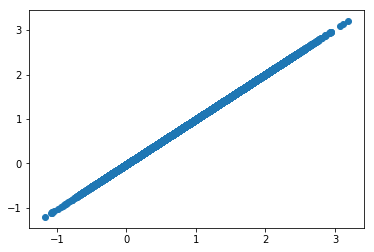

In [94]:
# effect on new sample

x_new1 = np.hstack((np.hstack((np.hstack((const, z_new)), np.ones((sample_size,1)))), z_new))
x_new0 = np.hstack((np.hstack((np.hstack((const, z_new)), np.zeros((sample_size,1)))), np.zeros((sample_size,1))))

ITE_on_newsample_nn = nn.predict(x_new1) - nn.predict(x_new0)

plt.scatter(true_ITE_newsample, ITE_on_newsample_nn)

In [95]:
diff_nn2 = np.subtract(true_ITE_newsample, ITE_on_newsample_nn)
dist_nn2 = np.sqrt(np.sum([i**2 for i in diff_nn2]))
dist_nn2

3.401964219443652